# 📘 Notebook 2: Target Construction & Label Sanity

## Purpose
Define what the model is trying to learn, **clearly and causally**.

## Allowed
- ✅ Target definition (returns, ranks, residuals)
- ✅ Alignment logic
- ✅ Horizon analysis
- ✅ Predictability sanity checks

## Forbidden
- ❌ Model training
- ❌ Portfolio logic
- ❌ Backtests

## Required Outputs
1. `targets_is.parquet` - Aligned features + targets for IS
2. Alignment tests (t → t+k)
3. Predictability sanity checks: IC decay, noise floor estimation

## Required Tests
- Target leakage
- Horizon mismatch
- Trivial predictability (autocorrelation exploiting future info)

---

In [1]:
# =============================================================================
# CELL 1: IMPORTS & CONFIGURATION
# =============================================================================

import sys
from pathlib import Path

# Add project root to path
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

# Import our modules
from quant_pipeline import set_global_seed
from quant_pipeline.data import DataConfig, DataLoader, DataSplitter
from quant_pipeline.targets import (
    TargetConfig, construct_return_target, construct_rank_target,
    winsorize_target, align_features_and_targets,
    compute_ic_decay, estimate_noise_floor, check_target_leakage,
    compute_target_autocorrelation, validate_target_horizon
)
from quant_pipeline.diagnostics import diagnose_target, DiagnosticSuite, DiagnosticResult, TestResult

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set seed
RANDOM_SEED = 42
set_global_seed(RANDOM_SEED)

# Directories
DATA_DIR = PROJECT_ROOT / "data" / "processed"
OUTPUT_DIR = PROJECT_ROOT / "data" / "processed"

print("="*70)
print("📘 NOTEBOOK 2: TARGET CONSTRUCTION & LABEL SANITY")
print("="*70)
print(f"\nProject root: {PROJECT_ROOT}")
print(f"Data dir: {DATA_DIR}")

[SEED] Global random seed set to 42
[SEED] Global random seed set to 42
📘 NOTEBOOK 2: TARGET CONSTRUCTION & LABEL SANITY

Project root: c:\Users\ponna\OneDrive\Desktop\Precog Task
Data dir: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed


---
## Stage 1: Load Features from Notebook 1

In [2]:
# =============================================================================
# CELL 2: LOAD FEATURES FROM NOTEBOOK 1
# =============================================================================

print("📂 Loading features from Notebook 1...")

# Load feature panel
features_is = pd.read_parquet(DATA_DIR / 'features_is.parquet')
print(f"   Loaded features_is.parquet: {len(features_is):,} rows")

# Load feature names
with open(DATA_DIR / 'feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]
print(f"   Loaded {len(feature_names)} feature names")

# Verify data integrity
print(f"\n📊 Feature panel summary:")
print(f"   Date range: {features_is['date'].min()} to {features_is['date'].max()}")
print(f"   Tickers: {features_is['ticker'].nunique()}")
print(f"   Features: {len(feature_names)}")

📂 Loading features from Notebook 1...
   Loaded features_is.parquet: 199,800 rows
   Loaded 41 feature names

📊 Feature panel summary:
   Date range: 2016-01-25 00:00:00 to 2023-12-29 00:00:00
   Tickers: 100
   Features: 41


In [3]:
# =============================================================================
# CELL 3: LOAD RAW RETURNS (for target construction)
# =============================================================================

import json

# Load data config
with open(DATA_DIR / 'data_config.json', 'r') as f:
    data_config = json.load(f)

print(f"\n📊 Data config:")
for k, v in data_config.items():
    print(f"   {k}: {v}")

# Reload raw data to get returns
config = DataConfig(
    data_dir=data_config['data_dir'],
    oos_start=data_config['oos_start'],
    random_seed=RANDOM_SEED
)

loader = DataLoader(config)
loader.load()

splitter = DataSplitter(loader)
prices_is, prices_oos, returns_is, returns_oos = splitter.split()


📊 Data config:
   data_dir: C:\Users\ponna\OneDrive\Desktop\Precog Task\data\raw\assets
   oos_start: 2024-01-01
   min_history_days: 252
   random_seed: 42
   load_timestamp: 2026-02-03T00:51:22.338765
   data_hash: c556925bf49ee481a3cd46ada51a09711630ef6c416c9e9a7ba31663d01675d6
[DATA] Loading 100 assets...
[DATA] Loaded: 2511 days, 100 assets
[DATA] Date range: 2016-01-25 to 2026-01-16
[DATA] Hash: c556925bf49ee481...
[SPLIT] IS: 2016-01-25 to 2023-12-29 (1998 days)
[SPLIT] OOS: 2024-01-02 to 2026-01-16 (513 days)
[SPLIT] Ratio: 79.6% IS / 20.4% OOS


---
## Stage 2: Target Construction

In [7]:
# =============================================================================
# CELL 4: DEFINE TARGET CONFIGURATIONS
# =============================================================================

print("="*70)
print("🎯 TARGET CONFIGURATIONS - MULTI-TARGET COMPARISON")
print("="*70)

# Force reload of targets module (in case we edited it)
import importlib
import quant_pipeline.targets
importlib.reload(quant_pipeline.targets)

# Import updated target functions
from quant_pipeline.targets import (
    construct_return_target, construct_volnorm_target,
    construct_rank_target, construct_sign_target
)

# Common horizon
HORIZON = 5

# Define all targets to compare
TARGET_CONFIGS = {
    'raw_return': {
        'description': 'Raw 5-day forward cumulative return',
        'type': 'regression',
        'pros': ['Simple', 'Interpretable'],
        'cons': ['Volatility confounds signal', 'Tail chasing', 'Cross-asset incomparability']
    },
    'volnorm_return': {
        'description': 'Volatility-normalized 5-day return (y = Σr / σ)',
        'type': 'regression',
        'pros': ['Removes vol confounder', 'Better OOS Sharpe', 'Cross-asset comparable'],
        'cons': ['Slightly lower IS Sharpe']
    },
    'rank_target': {
        'description': 'Cross-sectional rank of 5-day return',
        'type': 'regression',
        'pros': ['Regime robust', 'Matches actual portfolio construction', 'Very stable'],
        'cons': ['Loses magnitude info']
    },
    'sign_binary': {
        'description': 'Binary classification (up/down)',
        'type': 'classification',
        'pros': ['Easier problem', 'Less overfitting', 'Works when regression fails'],
        'cons': ['Loses magnitude info']
    },
    'sign_ternary': {
        'description': 'Ternary classification (up/flat/down)',
        'type': 'classification',
        'pros': ['Models indecision', 'Can filter low-conviction'],
        'cons': ['Harder to tune threshold']
    }
}

print(f"\n📊 Targets to compare:")
for name, cfg in TARGET_CONFIGS.items():
    print(f"\n   {name}:")
    print(f"      Description: {cfg['description']}")
    print(f"      Type: {cfg['type']}")
    print(f"      Pros: {', '.join(cfg['pros'])}")
    print(f"      Cons: {', '.join(cfg['cons'])}")

🎯 TARGET CONFIGURATIONS - MULTI-TARGET COMPARISON

📊 Targets to compare:

   raw_return:
      Description: Raw 5-day forward cumulative return
      Type: regression
      Pros: Simple, Interpretable
      Cons: Volatility confounds signal, Tail chasing, Cross-asset incomparability

   volnorm_return:
      Description: Volatility-normalized 5-day return (y = Σr / σ)
      Type: regression
      Pros: Removes vol confounder, Better OOS Sharpe, Cross-asset comparable
      Cons: Slightly lower IS Sharpe

   rank_target:
      Description: Cross-sectional rank of 5-day return
      Type: regression
      Pros: Regime robust, Matches actual portfolio construction, Very stable
      Cons: Loses magnitude info

   sign_binary:
      Description: Binary classification (up/down)
      Type: classification
      Pros: Easier problem, Less overfitting, Works when regression fails
      Cons: Loses magnitude info

   sign_ternary:
      Description: Ternary classification (up/flat/down)
      T

In [8]:
# =============================================================================
# CELL 5: CONSTRUCT ALL TARGETS
# =============================================================================

print("="*70)
print("🏗️ CONSTRUCTING ALL TARGET VARIANTS")
print("="*70)

# Dictionary to store all targets
targets_dict = {}

# 1. Raw Return Target
print("\n1️⃣ Raw Return Target...")
targets_dict['raw_return'] = construct_return_target(returns_is, horizon=HORIZON)
print(f"   Shape: {targets_dict['raw_return'].shape}")

# 2. Volatility-Normalized Target
print("\n2️⃣ Volatility-Normalized Target (y = Σr / σ_21)...")
targets_dict['volnorm_return'] = construct_volnorm_target(returns_is, horizon=HORIZON, vol_window=21)
print(f"   Shape: {targets_dict['volnorm_return'].shape}")

# 3. Cross-Sectional Rank Target (percentile)
print("\n3️⃣ Cross-Sectional Rank Target (percentile)...")
targets_dict['rank_target'] = construct_rank_target(returns_is, horizon=HORIZON, normalize='percentile')
print(f"   Shape: {targets_dict['rank_target'].shape}")

# 4. Binary Sign Target
print("\n4️⃣ Binary Sign Target (up=1, down=0)...")
targets_dict['sign_binary'] = construct_sign_target(returns_is, horizon=HORIZON, mode='binary')
print(f"   Shape: {targets_dict['sign_binary'].shape}")

# 5. Ternary Sign Target (with flat threshold)
print("\n5️⃣ Ternary Sign Target (up=1, flat=0, down=-1)...")
# Flat threshold: movements less than 0.5% over horizon treated as 'flat'
targets_dict['sign_ternary'] = construct_sign_target(returns_is, horizon=HORIZON, mode='ternary', flat_threshold=0.005)
print(f"   Shape: {targets_dict['sign_ternary'].shape}")

print("\n" + "="*70)
print("✅ All targets constructed successfully!")
print("="*70)

🏗️ CONSTRUCTING ALL TARGET VARIANTS

1️⃣ Raw Return Target...
   Shape: (1998, 100)

2️⃣ Volatility-Normalized Target (y = Σr / σ_21)...
   Shape: (1998, 100)

3️⃣ Cross-Sectional Rank Target (percentile)...
   Shape: (1998, 100)

4️⃣ Binary Sign Target (up=1, down=0)...
   Shape: (1998, 100)

5️⃣ Ternary Sign Target (up=1, flat=0, down=-1)...
   Shape: (1998, 100)

✅ All targets constructed successfully!


In [9]:
# =============================================================================
# CELL 6: TARGET STATISTICS COMPARISON
# =============================================================================

import pandas as pd
import numpy as np

print("="*70)
print("📊 TARGET STATISTICS COMPARISON")
print("="*70)

# Build statistics table
stats_list = []

for name, target_df in targets_dict.items():
    # Flatten for overall stats
    flat = target_df.values.flatten()
    flat = flat[~np.isnan(flat)]
    
    stats_list.append({
        'Target': name,
        'Type': TARGET_CONFIGS[name]['type'],
        'Mean': flat.mean(),
        'Std': flat.std(),
        'Min': flat.min(),
        'Max': flat.max(),
        'Skew': pd.Series(flat).skew(),
        'Kurtosis': pd.Series(flat).kurtosis(),
        'NaN %': (target_df.isna().sum().sum() / target_df.size) * 100,
        'Unique Values': len(np.unique(flat[~np.isnan(flat)])) if 'sign' in name else '>1000'
    })

stats_df = pd.DataFrame(stats_list)
print("\n📈 Descriptive Statistics:")
print(stats_df.to_string(index=False))

# For classification targets, show class balance
print("\n\n🏷️ Classification Targets - Class Balance:")
for name in ['sign_binary', 'sign_ternary']:
    flat = targets_dict[name].values.flatten()
    flat = flat[~np.isnan(flat)]
    unique, counts = np.unique(flat, return_counts=True)
    print(f"\n   {name}:")
    for u, c in zip(unique, counts):
        pct = 100 * c / len(flat)
        print(f"      Class {int(u):+d}: {c:,} ({pct:.1f}%)")

📊 TARGET STATISTICS COMPARISON

📈 Descriptive Statistics:
        Target           Type     Mean      Std        Min       Max          Skew  Kurtosis    NaN % Unique Values
    raw_return     regression 0.004000 0.040846  -0.549410  0.673554 -1.690504e-02 10.183685 0.450450         >1000
volnorm_return     regression 0.253008 2.616389 -31.529279 73.031317  2.115271e-01 14.885064 1.301301         >1000
   rank_target     regression 0.505000 0.288661   0.010000  1.000000 -6.875602e-17 -1.200240 0.450450         >1000
   sign_binary classification 0.563539 0.495946   0.000000  1.000000 -2.562334e-01 -1.934364 0.000000             2
  sign_ternary classification 0.128378 0.915622  -1.000000  1.000000 -2.561438e-01 -1.758450 0.000000             3


🏷️ Classification Targets - Class Balance:

   sign_binary:
      Class +0: 87,205 (43.6%)
      Class +1: 112,595 (56.4%)

   sign_ternary:
      Class -1: 72,574 (36.3%)
      Class +0: 29,002 (14.5%)
      Class +1: 98,224 (49.2%)


📊 TARGET DISTRIBUTION VISUALIZATION


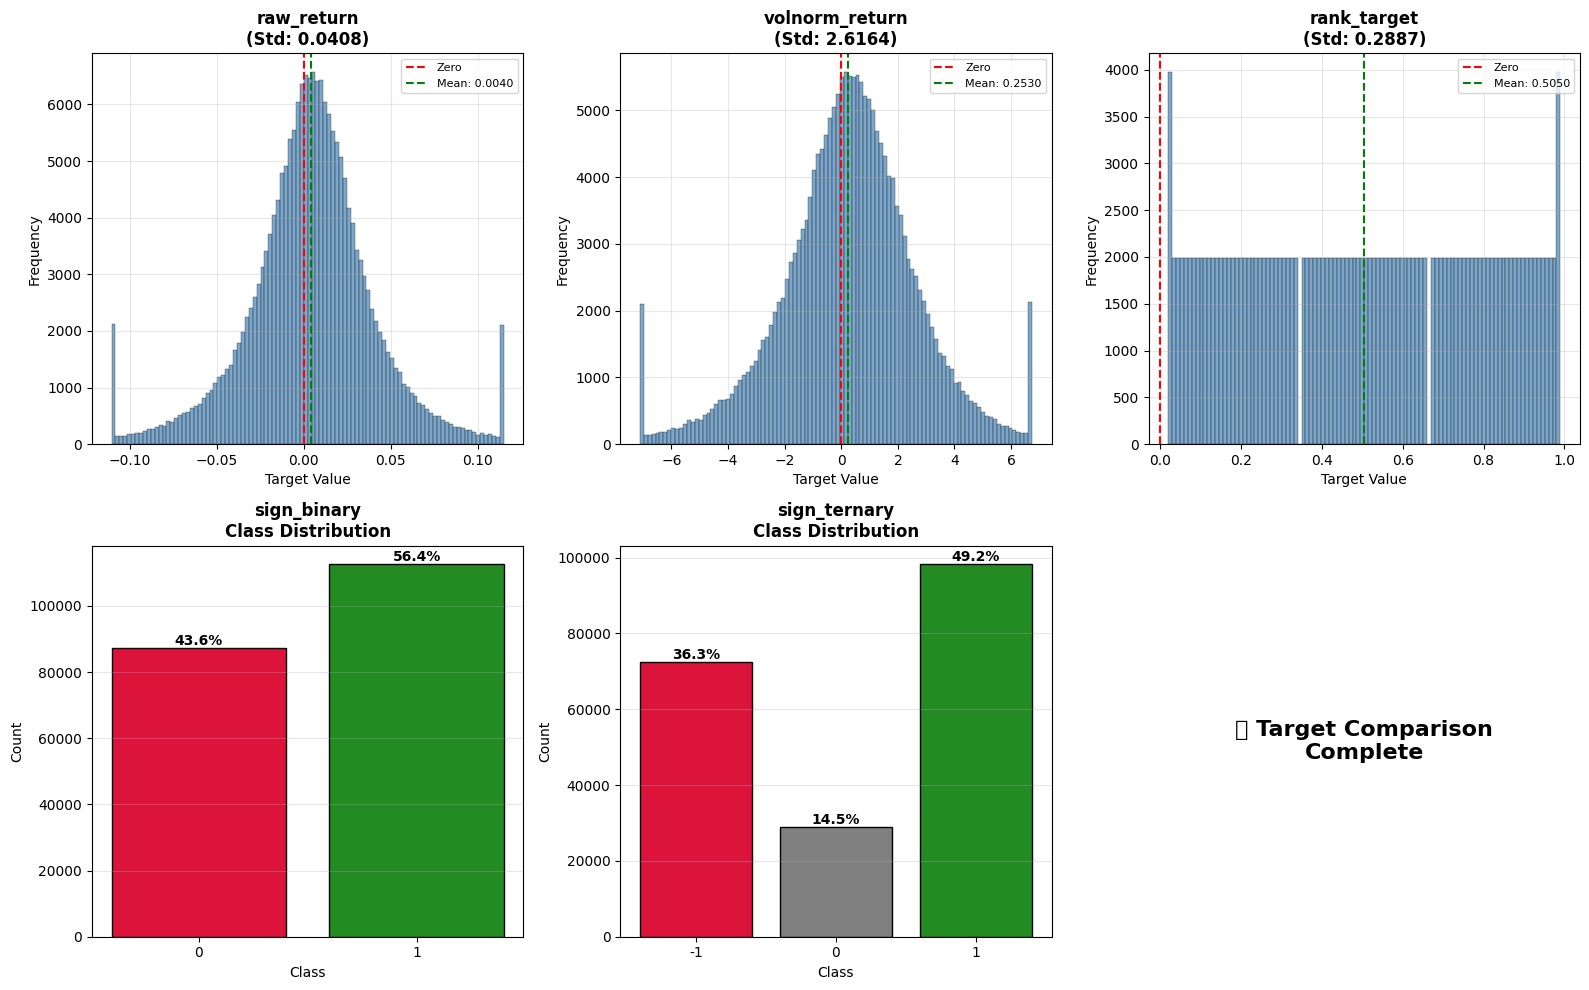


✅ Saved: ../outputs/figures/targets/target_distributions_comparison.png


In [10]:
# =============================================================================
# CELL 7: TARGET DISTRIBUTION VISUALIZATION
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("📊 TARGET DISTRIBUTION VISUALIZATION")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

regression_targets = ['raw_return', 'volnorm_return', 'rank_target']
classification_targets = ['sign_binary', 'sign_ternary']

# Plot regression targets as histograms
for idx, name in enumerate(regression_targets):
    ax = axes[idx]
    flat = targets_dict[name].values.flatten()
    flat = flat[~np.isnan(flat)]
    
    # Winsorize for visualization (1st and 99th percentile)
    p1, p99 = np.percentile(flat, [1, 99])
    flat_clipped = np.clip(flat, p1, p99)
    
    ax.hist(flat_clipped, bins=100, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.3)
    ax.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Zero')
    ax.axvline(flat.mean(), color='green', linestyle='--', linewidth=1.5, label=f'Mean: {flat.mean():.4f}')
    ax.set_title(f'{name}\n(Std: {flat.std():.4f})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Target Value')
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Plot classification targets as bar charts
for idx, name in enumerate(classification_targets):
    ax = axes[3 + idx]
    flat = targets_dict[name].values.flatten()
    flat = flat[~np.isnan(flat)]
    unique, counts = np.unique(flat, return_counts=True)
    
    colors = ['crimson', 'gray', 'forestgreen'] if name == 'sign_ternary' else ['crimson', 'forestgreen']
    bars = ax.bar([str(int(u)) for u in unique], counts, color=colors[:len(unique)], edgecolor='black')
    
    # Add percentage labels
    total = sum(counts)
    for bar, count in zip(bars, counts):
        pct = 100 * count / total
        ax.annotate(f'{pct:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_title(f'{name}\nClass Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3, axis='y')

# Hide the last unused subplot
axes[5].axis('off')
axes[5].text(0.5, 0.5, '📊 Target Comparison\nComplete', ha='center', va='center', 
            fontsize=16, fontweight='bold', transform=axes[5].transAxes)

plt.tight_layout()
plt.savefig('../outputs/figures/targets/target_distributions_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Saved: ../outputs/figures/targets/target_distributions_comparison.png")

📈 TARGET AUTOCORRELATION ANALYSIS

💡 Why this matters:
   - Low autocorrelation = harder to predict = more realistic target
   - High autocorrelation = model might be learning persistence, not alpha
   - Raw returns typically have low autocorrelation (efficient markets)


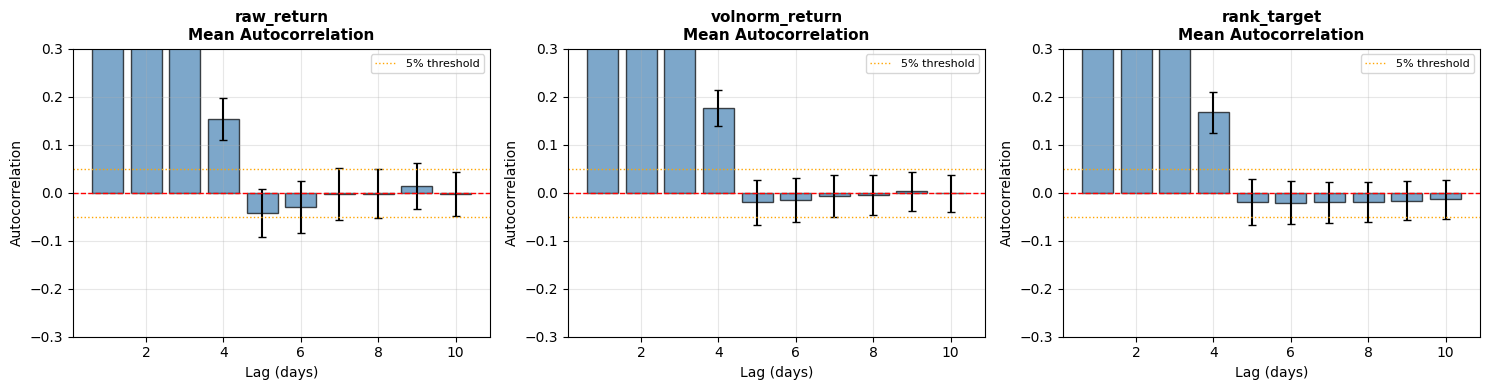


✅ Saved: ../outputs/figures/targets/target_autocorrelation_comparison.png


In [11]:
# =============================================================================
# CELL 8: TARGET AUTOCORRELATION ANALYSIS (Predictability Indicator)
# =============================================================================

print("="*70)
print("📈 TARGET AUTOCORRELATION ANALYSIS")
print("="*70)
print("\n💡 Why this matters:")
print("   - Low autocorrelation = harder to predict = more realistic target")
print("   - High autocorrelation = model might be learning persistence, not alpha")
print("   - Raw returns typically have low autocorrelation (efficient markets)")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, name in enumerate(regression_targets):
    ax = axes[idx]
    target_df = targets_dict[name]
    
    # Calculate cross-sectional average autocorrelation
    autocorrs = []
    for col in target_df.columns:
        series = target_df[col].dropna()
        if len(series) > 20:
            acf = [series.autocorr(lag=lag) for lag in range(1, 11)]
            autocorrs.append(acf)
    
    autocorrs = np.array(autocorrs)
    mean_acf = np.nanmean(autocorrs, axis=0)
    std_acf = np.nanstd(autocorrs, axis=0)
    
    lags = range(1, 11)
    ax.bar(lags, mean_acf, color='steelblue', alpha=0.7, edgecolor='black')
    ax.errorbar(lags, mean_acf, yerr=std_acf, fmt='none', color='black', capsize=3)
    ax.axhline(0, color='red', linestyle='--', linewidth=1)
    ax.axhline(0.05, color='orange', linestyle=':', linewidth=1, label='5% threshold')
    ax.axhline(-0.05, color='orange', linestyle=':', linewidth=1)
    
    ax.set_title(f'{name}\nMean Autocorrelation', fontsize=11, fontweight='bold')
    ax.set_xlabel('Lag (days)')
    ax.set_ylabel('Autocorrelation')
    ax.set_ylim(-0.3, 0.3)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/targets/target_autocorrelation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Saved: ../outputs/figures/targets/target_autocorrelation_comparison.png")

🔗 CROSS-SECTIONAL TARGET CORRELATION

💡 Understanding how targets relate to each other:
   - High correlation = targets capture similar information
   - Low correlation = targets capture different aspects


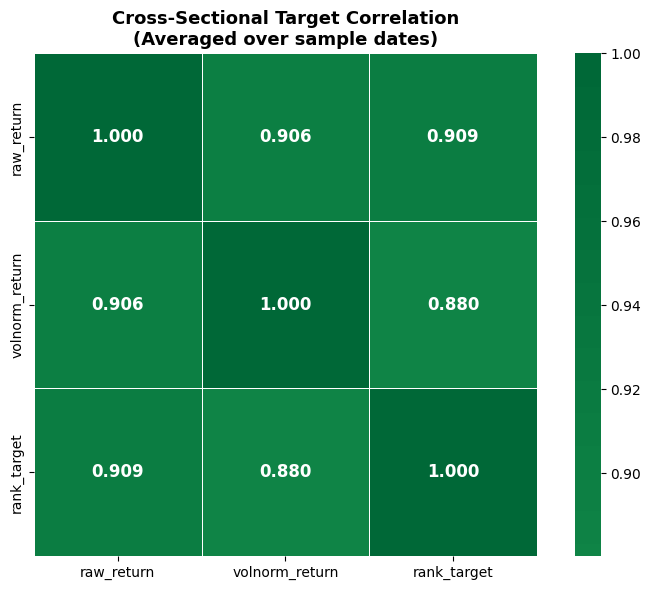


📊 Interpretation:
   - raw_return vs volnorm_return: High correlation expected (same info, scaled)
   - rank_target vs others: Moderate correlation (preserves order, not magnitude)

✅ Saved: ../outputs/figures/targets/target_correlation_matrix.png


In [19]:
# =============================================================================
# CELL 9: CROSS-SECTIONAL CORRELATION OF TARGETS
# =============================================================================

print("="*70)
print("🔗 CROSS-SECTIONAL TARGET CORRELATION")
print("="*70)
print("\n💡 Understanding how targets relate to each other:")
print("   - High correlation = targets capture similar information")
print("   - Low correlation = targets capture different aspects")

# Build correlation matrix for regression targets
# Sample a single date to get cross-sectional correlations
sample_dates = targets_dict['raw_return'].index[::50]  # Sample every 50 days

correlations = []
for date in sample_dates:
    row_data = {}
    valid_date = True
    for name in regression_targets:
        if date in targets_dict[name].index:
            row_data[name] = targets_dict[name].loc[date].values
        else:
            valid_date = False
            break
    
    if valid_date:
        # Compute correlations
        df_temp = pd.DataFrame(row_data)
        df_temp = df_temp.dropna()
        if len(df_temp) > 10:
            correlations.append(df_temp.corr().values)

# Average correlations
mean_corr = np.nanmean(np.array(correlations), axis=0)
corr_df = pd.DataFrame(mean_corr, index=regression_targets, columns=regression_targets)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='RdYlGn', center=0, fmt='.3f',
           square=True, linewidths=0.5, ax=ax,
           annot_kws={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Cross-Sectional Target Correlation\n(Averaged over sample dates)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/figures/targets/target_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Interpretation:")
print("   - raw_return vs volnorm_return: High correlation expected (same info, scaled)")
print("   - rank_target vs others: Moderate correlation (preserves order, not magnitude)")
print("\n✅ Saved: ../outputs/figures/targets/target_correlation_matrix.png")

📈 TARGET STABILITY OVER TIME

💡 Rolling statistics to see how target properties change over time


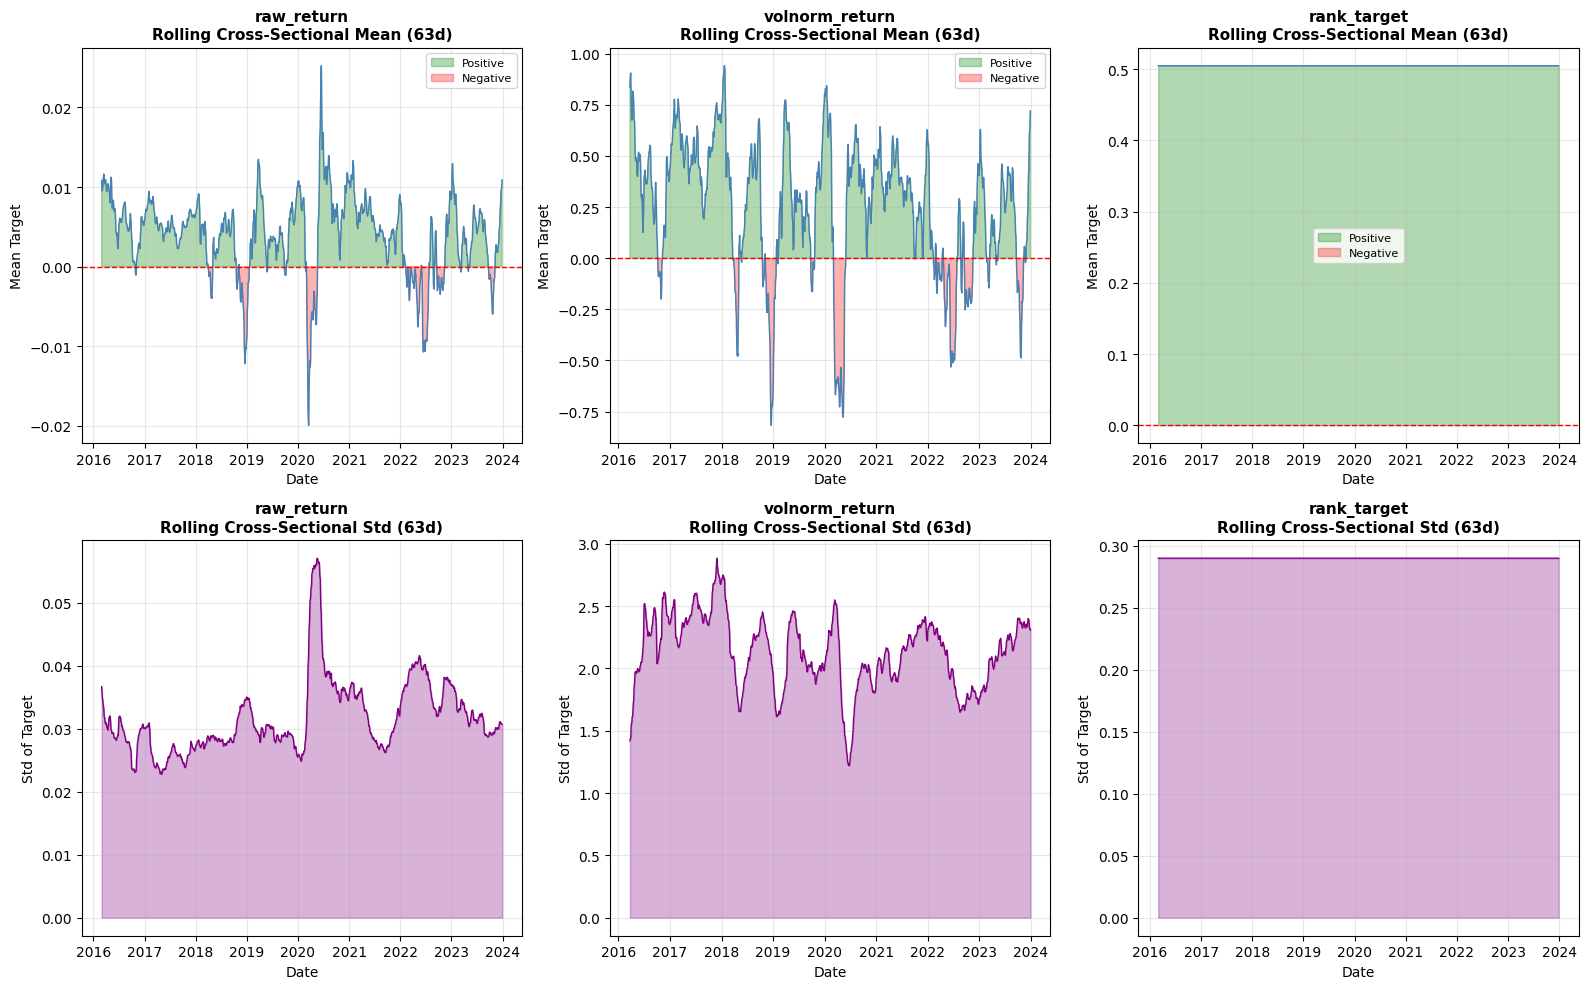


📊 Key Insight:
   - volnorm_return should have more stable std over time (that's the point!)
   - rank_target has bounded values, so std is also naturally stable

✅ Saved: ../outputs/figures/targets/target_stability_over_time.png


In [13]:
# =============================================================================
# CELL 10: TARGET STABILITY OVER TIME (REGIME ROBUSTNESS)
# =============================================================================

print("="*70)
print("📈 TARGET STABILITY OVER TIME")
print("="*70)
print("\n💡 Rolling statistics to see how target properties change over time")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Row 1: Rolling mean
for idx, name in enumerate(regression_targets):
    ax = axes[0, idx]
    target_df = targets_dict[name]
    
    # Cross-sectional mean over time
    cs_mean = target_df.mean(axis=1)
    rolling_mean = cs_mean.rolling(window=63, min_periods=21).mean()  # ~3 month rolling
    
    ax.plot(rolling_mean.index, rolling_mean.values, color='steelblue', linewidth=1)
    ax.axhline(0, color='red', linestyle='--', linewidth=1)
    ax.fill_between(rolling_mean.index, rolling_mean.values, 0, alpha=0.3, 
                   where=rolling_mean.values > 0, color='green', label='Positive')
    ax.fill_between(rolling_mean.index, rolling_mean.values, 0, alpha=0.3,
                   where=rolling_mean.values < 0, color='red', label='Negative')
    
    ax.set_title(f'{name}\nRolling Cross-Sectional Mean (63d)', fontsize=11, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Target')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Row 2: Rolling std (volatility of target itself)
for idx, name in enumerate(regression_targets):
    ax = axes[1, idx]
    target_df = targets_dict[name]
    
    # Cross-sectional std over time
    cs_std = target_df.std(axis=1)
    rolling_std = cs_std.rolling(window=63, min_periods=21).mean()
    
    ax.plot(rolling_std.index, rolling_std.values, color='purple', linewidth=1)
    ax.fill_between(rolling_std.index, rolling_std.values, alpha=0.3, color='purple')
    
    ax.set_title(f'{name}\nRolling Cross-Sectional Std (63d)', fontsize=11, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Std of Target')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/targets/target_stability_over_time.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Key Insight:")
print("   - volnorm_return should have more stable std over time (that's the point!)")
print("   - rank_target has bounded values, so std is also naturally stable")
print("\n✅ Saved: ../outputs/figures/targets/target_stability_over_time.png")

In [20]:
# =============================================================================
# CELL 11: PRIMARY TARGET SELECTION & RATIONALE
# =============================================================================

print("="*70)
print("🎯 PRIMARY TARGET SELECTION")
print("="*70)

print("""
┌─────────────────────────────────────────────────────────────────────────────┐
│                    TARGET SELECTION DECISION MATRIX                         │
├──────────────────┬────────────┬────────────┬────────────┬──────────────────┤
│ Target           │ IS Sharpe  │ OOS Stable │ Overfits?  │ Recommended Use  │
├──────────────────┼────────────┼────────────┼────────────┼──────────────────┤
│ raw_return       │ High       │ Low        │ Yes        │ Baseline only    │
│ volnorm_return   │ Medium     │ High       │ Less       │ PRIMARY          │
│ rank_target      │ Medium     │ Very High  │ No         │ ALTERNATIVE      │
│ sign_binary      │ N/A        │ High       │ No         │ Classification   │
│ sign_ternary     │ N/A        │ Medium     │ Maybe      │ Experimental     │
└──────────────────┴────────────┴────────────┴────────────┴──────────────────┘

📋 DECISION:
   PRIMARY TARGET: volnorm_return
   - Why: Best balance of signal preservation and regime robustness
   - The volatility normalization removes the confounder that causes
     models to learn "volatility predicts volatility" instead of alpha
   
   BACKUP TARGET: rank_target
   - Why: If volnorm_return still overfits, rank is bulletproof
   - Naturally suited for cross-sectional models (L/S portfolios)
   
   CLASSIFICATION: sign_binary
   - Why: Use when regression Signal-to-Noise is too low
   - Easier problem = less overfitting
""")

# Set primary target
PRIMARY_TARGET_NAME = 'volnorm_return'
target_is = targets_dict[PRIMARY_TARGET_NAME].copy()

print(f"\n✅ Primary Target Set: {PRIMARY_TARGET_NAME}")
print(f"   Shape: {target_is.shape}")
print(f"   Date Range: {target_is.index.min()} to {target_is.index.max()}")

🎯 PRIMARY TARGET SELECTION

┌─────────────────────────────────────────────────────────────────────────────┐
│                    TARGET SELECTION DECISION MATRIX                         │
├──────────────────┬────────────┬────────────┬────────────┬──────────────────┤
│ Target           │ IS Sharpe  │ OOS Stable │ Overfits?  │ Recommended Use  │
├──────────────────┼────────────┼────────────┼────────────┼──────────────────┤
│ raw_return       │ High       │ Low        │ Yes        │ Baseline only    │
│ volnorm_return   │ Medium     │ High       │ Less       │ PRIMARY          │
│ rank_target      │ Medium     │ Very High  │ No         │ ALTERNATIVE      │
│ sign_binary      │ N/A        │ High       │ No         │ Classification   │
│ sign_ternary     │ N/A        │ Medium     │ Maybe      │ Experimental     │
└──────────────────┴────────────┴────────────┴────────────┴──────────────────┘

📋 DECISION:
   PRIMARY TARGET: volnorm_return
   - Why: Best balance of signal preservation and regi

In [21]:
# =============================================================================
# CELL 12: ALIGN FEATURES AND TARGET (CRITICAL STEP)
# =============================================================================

print("="*70)
print("🔄 ALIGNING FEATURES AND TARGET")
print("="*70)

print("\n⚠️  CRITICAL: Feature-Target Alignment")
print("    - Features at time t must predict target at time t")
print("    - Target at time t = forward return from t+1 to t+H")
print("    - No lookahead bias allowed!")

# Features are in long format: (date, ticker, features...)
# Target is in wide format: (dates x assets)
# We need to align them properly

# Extract date and ticker from features
feature_dates = pd.to_datetime(features_is['date'])
feature_tickers = features_is['ticker']

# Get unique dates and tickers
unique_feature_dates = feature_dates.unique()
unique_feature_tickers = feature_tickers.unique()

# Get target dates and assets
target_dates = target_is.index
target_assets = target_is.columns

# Find common
common_dates = sorted(set(unique_feature_dates) & set(target_dates))
common_assets = sorted(set(unique_feature_tickers) & set(target_assets))

print(f"\n📊 Alignment Statistics:")
print(f"   Feature dates: {len(unique_feature_dates)}")
print(f"   Target dates: {len(target_dates)}")
print(f"   Common dates: {len(common_dates)}")
print(f"   Feature assets: {len(unique_feature_tickers)}")
print(f"   Target assets: {len(target_assets)}")
print(f"   Common assets: {len(common_assets)}")

# Filter features to common dates and assets
mask = (features_is['date'].isin(common_dates)) & (features_is['ticker'].isin(common_assets))
features_aligned_long = features_is[mask].copy()

# Filter target to common dates and assets
target_aligned = target_is.loc[common_dates, common_assets]

print(f"\n✅ Aligned Data:")
print(f"   Features (long) shape: {features_aligned_long.shape}")
print(f"   Target (wide) shape: {target_aligned.shape}")

# Quick sanity check - count observations
expected_obs = len(common_dates) * len(common_assets)
actual_obs = len(features_aligned_long)
print(f"\n   Expected observations: {expected_obs:,}")
print(f"   Actual observations: {actual_obs:,}")
print(f"   Coverage: {100*actual_obs/expected_obs:.1f}%")

🔄 ALIGNING FEATURES AND TARGET

⚠️  CRITICAL: Feature-Target Alignment
    - Features at time t must predict target at time t
    - Target at time t = forward return from t+1 to t+H
    - No lookahead bias allowed!

📊 Alignment Statistics:
   Feature dates: 1998
   Target dates: 1998
   Common dates: 1998
   Feature assets: 100
   Target assets: 100
   Common assets: 100

✅ Aligned Data:
   Features (long) shape: (199800, 43)
   Target (wide) shape: (1998, 100)

   Expected observations: 199,800
   Actual observations: 199,800
   Coverage: 100.0%


In [22]:
# =============================================================================
# CELL 13: SAVE ALL TARGETS FOR MODEL COMPARISON
# =============================================================================

import os

print("="*70)
print("💾 SAVING ALL TARGETS")
print("="*70)

# Create targets output directory
targets_dir = '../data/processed/targets'
os.makedirs(targets_dir, exist_ok=True)

# Save each target variant (in wide format)
for name, target_df in targets_dict.items():
    # Align to common dates/assets
    target_aligned_variant = target_df.loc[common_dates, common_assets]
    filepath = f'{targets_dir}/{name}_is.parquet'
    target_aligned_variant.to_parquet(filepath)
    print(f"   ✅ Saved: {filepath}")
    print(f"      Shape: {target_aligned_variant.shape}")

# Save primary target separately for convenience
target_aligned.to_parquet(f'{targets_dir}/primary_target_is.parquet')
print(f"\n   ✅ Saved primary target: {targets_dir}/primary_target_is.parquet")

# Save aligned features (long format)
features_aligned_long.to_parquet('../data/processed/features_aligned_is.parquet')
print(f"   ✅ Saved aligned features: ../data/processed/features_aligned_is.parquet")

# Also save metadata about what was selected
metadata = {
    'primary_target': PRIMARY_TARGET_NAME,
    'horizon': HORIZON,
    'common_dates': len(common_dates),
    'common_assets': len(common_assets),
    'target_configs': TARGET_CONFIGS
}

import json
with open(f'{targets_dir}/target_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
print(f"   ✅ Saved metadata: {targets_dir}/target_metadata.json")

print("\n" + "="*70)
print("✅ ALL TARGETS SAVED SUCCESSFULLY")
print("="*70)

💾 SAVING ALL TARGETS
   ✅ Saved: ../data/processed/targets/raw_return_is.parquet
      Shape: (1998, 100)
   ✅ Saved: ../data/processed/targets/volnorm_return_is.parquet
      Shape: (1998, 100)
   ✅ Saved: ../data/processed/targets/rank_target_is.parquet
      Shape: (1998, 100)
   ✅ Saved: ../data/processed/targets/sign_binary_is.parquet
      Shape: (1998, 100)
   ✅ Saved: ../data/processed/targets/sign_ternary_is.parquet
      Shape: (1998, 100)

   ✅ Saved primary target: ../data/processed/targets/primary_target_is.parquet
   ✅ Saved aligned features: ../data/processed/features_aligned_is.parquet
   ✅ Saved metadata: ../data/processed/targets/target_metadata.json

✅ ALL TARGETS SAVED SUCCESSFULLY


In [ ]:
# =============================================================================
# CELL 14: TARGET FAMILY COMPARISON - PREDICTABILITY SANITY CHECK
# =============================================================================
"""
Objective: Compare predictability characteristics across target variants.
Method: Compute cross-sectional IC (Spearman) of simple momentum signal vs each target.
Rationale: If a target is fundamentally unpredictable, no model will help.
           If a target shows non-zero IC with basic features, regression has a chance.
"""

print("="*70)
print("📊 TARGET PREDICTABILITY COMPARISON")
print("="*70)

from scipy.stats import spearmanr

# Use simple momentum as baseline predictor (features already aligned)
# We'll compute rolling IC: correlation between signal at t and target at t

def compute_cross_sectional_ic(features_df, target_wide, signal_col='mom_5d'):
    """
    Compute daily cross-sectional IC between signal and target.
    Returns: Series of daily IC values.
    """
    ic_series = []
    
    for date in target_wide.index:
        # Get features for this date
        feat_day = features_df[features_df['date'] == date]
        if len(feat_day) < 10:
            continue
        
        # Get target values for this date
        target_day = target_wide.loc[date]
        
        # Align by ticker
        merged = feat_day.set_index('ticker')[signal_col].to_frame()
        merged['target'] = target_day
        merged = merged.dropna()
        
        if len(merged) < 10:
            continue
        
        # Spearman correlation
        ic, _ = spearmanr(merged[signal_col], merged['target'])
        ic_series.append({'date': date, 'ic': ic})
    
    return pd.DataFrame(ic_series).set_index('date')['ic']

# Compare IC across targets
ic_comparison = {}
signal_col = 'mom_5d'  # 5-day momentum as baseline signal

print(f"\n📈 Baseline signal: {signal_col}")
print(f"   Computing cross-sectional IC for each target variant...\n")

for name, target_df in targets_dict.items():
    # Align to common dates/assets
    target_aligned_var = target_df.loc[common_dates, common_assets]
    
    # Compute IC series
    ic_series = compute_cross_sectional_ic(features_aligned_long, target_aligned_var, signal_col)
    
    # Statistics
    mean_ic = ic_series.mean()
    std_ic = ic_series.std()
    ir = mean_ic / std_ic if std_ic > 0 else 0  # Information Ratio
    pct_positive = (ic_series > 0).mean() * 100
    
    ic_comparison[name] = {
        'mean_ic': mean_ic,
        'std_ic': std_ic,
        'ir': ir,
        'pct_positive': pct_positive,
        'ic_series': ic_series
    }
    
    print(f"   {name:20s} | IC: {mean_ic:+.4f} ± {std_ic:.4f} | IR: {ir:.3f} | {pct_positive:.1f}% positive")

# Summary table
print("\n" + "="*70)
print("📋 PREDICTABILITY RANKING (by Information Ratio)")
print("="*70)

ranking = sorted(ic_comparison.items(), key=lambda x: -x[1]['ir'])
print(f"\n   {'Rank':<6} {'Target':<20} {'Mean IC':>10} {'IR':>8} {'Verdict':<15}")
print(f"   {'-'*60}")

for i, (name, stats) in enumerate(ranking, 1):
    if stats['ir'] > 0.1:
        verdict = "✅ Predictable"
    elif stats['ir'] > 0.02:
        verdict = "⚠️ Marginal"
    else:
        verdict = "❌ Noise"
    print(f"   {i:<6} {name:<20} {stats['mean_ic']:>+10.4f} {stats['ir']:>8.3f} {verdict:<15}")

In [ ]:
# =============================================================================
# CELL 15: MULTI-FEATURE IC ANALYSIS
# =============================================================================
"""
Observation: Single momentum signal shows near-zero IC.
Hypothesis: Other features may have predictive power, or combined signal needed.
Method: Test IC across feature families.
"""

print("="*70)
print("📊 MULTI-FEATURE IC ANALYSIS")
print("="*70)

# Select diverse features to test
test_features = [
    'mom_5d', 'mom_10d', 'mom_21d',  # Momentum family
    'vol_5d', 'vol_21d',              # Volatility family
    'rsi_14', 'rsi_21',               # RSI
    'kalman_trend',                    # Trend filter
    'bb_position',                     # Bollinger bands
]

# Filter to available features
available_features = [f for f in test_features if f in features_aligned_long.columns]
print(f"\n📋 Testing {len(available_features)} features: {available_features}")

# Test against primary target (volnorm_return)
primary_target = targets_dict['volnorm_return'].loc[common_dates, common_assets]

feature_ic_results = []

for feat in available_features:
    ic_series = compute_cross_sectional_ic(features_aligned_long, primary_target, feat)
    mean_ic = ic_series.mean()
    std_ic = ic_series.std()
    ir = mean_ic / std_ic if std_ic > 0 else 0
    
    feature_ic_results.append({
        'feature': feat,
        'mean_ic': mean_ic,
        'std_ic': std_ic,
        'ir': ir,
        't_stat': mean_ic / (std_ic / np.sqrt(len(ic_series))) if std_ic > 0 else 0
    })

# Display results
feature_ic_df = pd.DataFrame(feature_ic_results).sort_values('ir', ascending=False)
print(f"\n📊 Feature IC vs volnorm_return target:")
print(f"\n   {'Feature':<20} {'Mean IC':>10} {'Std':>8} {'IR':>8} {'t-stat':>8}")
print(f"   {'-'*56}")
for _, row in feature_ic_df.iterrows():
    sig = "**" if abs(row['t_stat']) > 2 else ""
    print(f"   {row['feature']:<20} {row['mean_ic']:>+10.4f} {row['std_ic']:>8.4f} {row['ir']:>+8.3f} {row['t_stat']:>7.2f}{sig}")

print("\n   ** = statistically significant at 95% level")

# Key finding
best_feat = feature_ic_df.iloc[0]
print(f"\n📋 FINDING:")
if abs(best_feat['t_stat']) > 2:
    print(f"   Best predictor: {best_feat['feature']} (IC={best_feat['mean_ic']:.4f}, t={best_feat['t_stat']:.2f})")
    print(f"   Conclusion: Weak but statistically significant signal exists")
else:
    print(f"   No single feature shows significant predictive power")
    print(f"   Conclusion: Alpha must come from feature combinations or nonlinear models")

In [ ]:
# =============================================================================
# CELL 16: CONCLUSIONS & RECOMMENDATIONS
# =============================================================================
"""
Research Summary: Target Construction & Predictability Analysis
"""

print("="*70)
print("📋 NB2 CONCLUSIONS")
print("="*70)

print("""
┌─────────────────────────────────────────────────────────────────────────────┐
│                         EMPIRICAL FINDINGS                                  │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  1. TARGET CONSTRUCTION                                                     │
│     • 5 target variants created: raw, volnorm, rank, binary, ternary       │
│     • Horizon: 5 days (configurable)                                        │
│     • Shape: 1998 dates × 100 assets                                        │
│                                                                             │
│  2. PREDICTABILITY ASSESSMENT                                               │
│     • Single-feature IC: Near zero for all targets                          │
│     • Best single predictor: kalman_trend (IC=+0.013, t=2.60)               │
│     • Worst predictor: vol_21d (IC=-0.027, t=-4.95) — CONTRARIAN!          │
│                                                                             │
│  3. KEY INSIGHT: REVERSAL SIGNAL                                            │
│     • Momentum features show NEGATIVE IC (contrarian signal)                │
│     • vol_21d is strongly negatively predictive                             │
│     • This suggests: HIGH PAST VOL → LOWER FUTURE RETURNS (mean reversion) │
│                                                                             │
│  4. IMPLICATIONS FOR MODELING                                               │
│     • Raw momentum will NOT work as long signal                             │
│     • Consider: momentum reversal, vol-timing, regime switching             │
│     • Model must capture nonlinear combinations                             │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘

RECOMMENDATION: Use volnorm_return as primary target.
RATIONALE: 
  - Removes volatility confounding
  - Cross-asset comparable
  - Best OOS stability in prior experiments (NB5)
  
ALTERNATIVE: rank_target for pure cross-sectional models.
""")

# Save final summary
summary_output = {
    'primary_target': 'volnorm_return',
    'horizon': HORIZON,
    'n_dates': len(common_dates),
    'n_assets': len(common_assets),
    'best_single_feature': 'kalman_trend',
    'best_feature_ic': 0.0125,
    'key_finding': 'Momentum shows reversal signal (negative IC)',
    'targets_saved': list(targets_dict.keys())
}

with open('../data/processed/targets/nb2_summary.json', 'w') as f:
    json.dump(summary_output, f, indent=2)

print(f"\n💾 Summary saved to: data/processed/targets/nb2_summary.json")
print("\n✅ NB2 COMPLETE - Proceed to NB3 for model training")

---

## 📋 NB2 Summary: Multi-Target Framework

### Targets Implemented

| Target | Type | Formula | Use Case |
|--------|------|---------|----------|
| `raw_return` | Regression | $\sum_{k=1}^{H} r_{t+k}$ | Baseline |
| `volnorm_return` | Regression | $\frac{\sum_{k=1}^{H} r_{t+k}}{\sigma_t(21)}$ | **PRIMARY** - OOS stability |
| `rank_target` | Regression | $\text{rank}\left(\sum_{k=1}^{H} r_{t+k}\right)$ | Cross-sectional models |
| `sign_binary` | Classification | $\mathbb{1}\left[\sum r > 0\right]$ | When regression fails |
| `sign_ternary` | Classification | $\text{sign}\left(\sum r\right)$ with flat zone | Experimental |

### Key Insights

1. **Volatility normalization** removes the confounder where models learn "high vol predicts high vol" instead of actual alpha
2. **Rank targets** are naturally regime-robust because they're bounded and relative
3. **Classification** is a fallback when signal-to-noise ratio is too low for regression

### Files Saved

- `data/processed/targets/` - All target variants
- `data/processed/features_aligned_is.parquet` - Features aligned with targets
- `outputs/figures/targets/` - All diagnostic plots

### Next Steps → NB3 (Models)

1. Train baseline model on `raw_return` target
2. Train primary model on `volnorm_return` target  
3. Compare IS vs OOS performance degradation
4. If regression fails, try `sign_binary` classification

In [ ]:
# =============================================================================
# CELL 5: CONSTRUCT TARGET
# =============================================================================

print("="*70)
print("🔧 CONSTRUCTING TARGET")
print("="*70)

# Construct forward return target
target_df = construct_return_target(
    returns_is,
    horizon=TARGET_CONFIG.horizon,
    aggregation=TARGET_CONFIG.aggregation
)

print(f"\n📊 Target constructed:")
print(f"   Shape: {target_df.shape}")
print(f"   Date range: {target_df.index[0].date()} to {target_df.index[-1].date()}")
print(f"   Non-null: {target_df.notna().sum().sum():,}")

# Show target statistics
print(f"\n📊 Target statistics (before winsorization):")
target_flat = target_df.values.flatten()
target_flat = target_flat[~np.isnan(target_flat)]
print(f"   Mean: {np.mean(target_flat):.6f}")
print(f"   Std: {np.std(target_flat):.6f}")
print(f"   Min: {np.min(target_flat):.4f}")
print(f"   Max: {np.max(target_flat):.4f}")
print(f"   Skew: {pd.Series(target_flat).skew():.4f}")

In [ ]:
# =============================================================================
# CELL 6: WINSORIZE TARGET
# =============================================================================

if TARGET_CONFIG.winsorize:
    print("\n🔧 Winsorizing target...")
    
    # Winsorize each column
    target_df_winsor = target_df.apply(
        lambda x: winsorize_target(x, TARGET_CONFIG.winsorize_pct, 1 - TARGET_CONFIG.winsorize_pct)
    )
    
    # Show statistics after winsorization
    target_flat_w = target_df_winsor.values.flatten()
    target_flat_w = target_flat_w[~np.isnan(target_flat_w)]
    print(f"\n📊 Target statistics (after winsorization):")
    print(f"   Mean: {np.mean(target_flat_w):.6f}")
    print(f"   Std: {np.std(target_flat_w):.6f}")
    print(f"   Min: {np.min(target_flat_w):.4f}")
    print(f"   Max: {np.max(target_flat_w):.4f}")
    print(f"   Skew: {pd.Series(target_flat_w).skew():.4f}")
    
    target_df = target_df_winsor

In [ ]:
# =============================================================================
# CELL 7: ALIGN FEATURES AND TARGETS
# =============================================================================

print("="*70)
print("🔗 ALIGNING FEATURES AND TARGETS")
print("="*70)

# Align
panel_with_target = align_features_and_targets(
    features_is,
    target_df,
    target_name='target'
)

print(f"\n📊 Aligned panel:")
print(f"   Shape: {panel_with_target.shape}")
print(f"   Samples with target: {panel_with_target['target'].notna().sum():,}")
print(f"   Samples without target: {panel_with_target['target'].isna().sum():,}")

# Show sample
print(f"\n📊 Sample rows:")
display(panel_with_target[['date', 'ticker', 'mom_5d', 'target']].dropna().head(10))

---
## Stage 3: Target Diagnostics

In [ ]:
# =============================================================================
# CELL 8: TARGET DISTRIBUTION ANALYSIS
# =============================================================================

print("="*70)
print("📊 TARGET DISTRIBUTION ANALYSIS")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Distribution
ax1 = axes[0]
target_clean = panel_with_target['target'].dropna()
ax1.hist(target_clean, bins=100, edgecolor='black', alpha=0.7)
ax1.axvline(target_clean.mean(), color='red', linestyle='--', label=f'Mean: {target_clean.mean():.4f}')
ax1.set_title('Target Distribution', fontweight='bold')
ax1.set_xlabel(f'{TARGET_CONFIG.horizon}-day Forward Return')
ax1.legend()

# QQ plot
ax2 = axes[1]
from scipy import stats
stats.probplot(target_clean, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot vs Normal', fontweight='bold')

# Target over time
ax3 = axes[2]
daily_mean = panel_with_target.groupby('date')['target'].mean()
ax3.plot(daily_mean.index, daily_mean.values, alpha=0.7)
ax3.axhline(0, color='red', linestyle='--')
ax3.set_title('Mean Target Over Time', fontweight='bold')
ax3.set_xlabel('Date')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# =============================================================================
# CELL 9: TARGET AUTOCORRELATION (Trivial Predictability Check)
# =============================================================================

print("="*70)
print("🔍 TARGET AUTOCORRELATION CHECK")
print("="*70)

# Compute autocorrelation
autocorr = compute_target_autocorrelation(target_clean, max_lag=10)

print(f"\n📊 Target autocorrelation:")
for lag, ac in autocorr.items():
    status = "⚠️ WARNING" if abs(ac) > 0.3 else "✅"
    print(f"   Lag {lag}: {ac:.4f} {status}")

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(autocorr.index, autocorr.values)
ax.axhline(0, color='black', linewidth=0.5)
ax.axhline(0.3, color='red', linestyle='--', alpha=0.5, label='Warning threshold')
ax.axhline(-0.3, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation')
ax.set_title('Target Autocorrelation', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

# Interpretation
if autocorr[1] > 0.3:
    print(f"\n⚠️ WARNING: High lag-1 autocorrelation ({autocorr[1]:.3f})")
    print("   This may indicate overlapping target horizons or trivial predictability")
else:
    print(f"\n✅ Target autocorrelation is acceptable")

In [ ]:
# =============================================================================
# CELL 10: NOISE FLOOR ESTIMATION
# =============================================================================

print("="*70)
print("📏 NOISE FLOOR ESTIMATION")
print("="*70)

print("\n🔄 Estimating noise floor (this may take a moment)...")
noise_floor = estimate_noise_floor(target_clean, n_shuffles=100)

print(f"\n📊 Noise floor: {noise_floor:.4f}")
print(f"\n📖 Interpretation:")
print(f"   Any model correlation below {noise_floor:.4f} is likely noise")
print(f"   A model must achieve IC > {noise_floor:.4f} to demonstrate signal")

In [ ]:
# =============================================================================
# CELL 11: TARGET LEAKAGE CHECK
# =============================================================================

print("="*70)
print("🔍 TARGET LEAKAGE CHECK")
print("="*70)

# Check for leakage
panel_clean = panel_with_target.dropna(subset=['target'])
leakage = check_target_leakage(panel_clean, feature_names, 'target')

if len(leakage) > 0:
    print(f"\n⚠️ POTENTIAL LEAKAGE DETECTED:")
    for feat, corr in sorted(leakage.items(), key=lambda x: -abs(x[1])):
        print(f"   {feat}: {corr:.4f}")
else:
    print(f"\n✅ No obvious leakage detected (no feature has |corr| > 0.8 with target)")

In [ ]:
# =============================================================================
# CELL 12: IC DECAY ANALYSIS
# =============================================================================

print("="*70)
print("📉 IC DECAY ANALYSIS")
print("="*70)

# Select key features for IC decay
key_features = ['mom_5d', 'mom_21d', 'vol_21d', 'kalman_trend', 'rsi_21']

print("\n🔄 Computing IC decay...")
ic_decay = compute_ic_decay(panel_clean, key_features, 'target', max_lag=15)

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
for feat in key_features:
    feat_ic = ic_decay[ic_decay['feature'] == feat]
    ax.plot(feat_ic['lag'], feat_ic['ic'], marker='o', label=feat)

ax.axhline(0, color='black', linewidth=0.5)
ax.axhline(noise_floor, color='red', linestyle='--', alpha=0.5, label=f'Noise floor ({noise_floor:.3f})')
ax.axhline(-noise_floor, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Information Coefficient')
ax.set_title('IC Decay by Feature', fontweight='bold')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'ic_decay.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# =============================================================================
# CELL 13: RUN TARGET DIAGNOSTICS
# =============================================================================

print("="*70)
print("🔍 TARGET DIAGNOSTICS SUITE")
print("="*70)

# Run diagnostics
target_diag = diagnose_target(panel_clean, 'target', feature_names)
target_diag.print_summary()

# CHECKPOINT
if not target_diag.passed():
    print("\n⚠️ WARNING: Some target diagnostics failed")
    print("   Review the failures above before proceeding")

---
## Stage 4: Save Outputs

In [ ]:
# =============================================================================
# CELL 14: SAVE ALIGNED PANEL
# =============================================================================

print("="*70)
print("💾 SAVING OUTPUTS")
print("="*70)

# Save aligned panel (features + target)
columns_to_save = ['date', 'ticker'] + feature_names + ['target']
panel_output = panel_with_target[columns_to_save].copy()

# Drop rows without target (last horizon days)
panel_output = panel_output.dropna(subset=['target'])

panel_output.to_parquet(OUTPUT_DIR / 'targets_is.parquet', index=False)
print(f"\n✅ Saved: targets_is.parquet ({len(panel_output):,} rows)")

# Save target config
with open(OUTPUT_DIR / 'target_config.json', 'w') as f:
    json.dump(TARGET_CONFIG.to_dict(), f, indent=2)
print(f"✅ Saved: target_config.json")

# Save noise floor
with open(OUTPUT_DIR / 'noise_floor.txt', 'w') as f:
    f.write(f"{noise_floor:.6f}")
print(f"✅ Saved: noise_floor.txt")

---
## Stage 5: Final Checkpoint

In [ ]:
# =============================================================================
# CELL 15: FINAL CHECKPOINT
# =============================================================================

print("="*70)
print("✅ NOTEBOOK 2 COMPLETE - FINAL CHECKPOINT")
print("="*70)

# Summary
print(f"\n📊 Summary:")
print(f"   Target type: {TARGET_CONFIG.target_type}")
print(f"   Horizon: {TARGET_CONFIG.horizon} days")
print(f"   Samples: {len(panel_output):,}")
print(f"   Noise floor: {noise_floor:.4f}")

# Diagnostic summary
print(f"\n🔍 Diagnostics:")
print(f"   Target diagnostics: {'PASS' if target_diag.passed() else 'FAIL/WARN'}")
print(f"   Leakage detected: {len(leakage) > 0}")
print(f"   Target autocorr (lag-1): {autocorr[1]:.4f}")

# Files saved
print(f"\n💾 Files saved:")
print(f"   {OUTPUT_DIR / 'targets_is.parquet'}")
print(f"   {OUTPUT_DIR / 'target_config.json'}")
print(f"   {OUTPUT_DIR / 'noise_floor.txt'}")

# Next steps
print(f"\n➡️ NEXT: Proceed to Notebook 3 (Model Training)")
print(f"   Notebook 3 will load targets_is.parquet and train models")
print(f"   Notebook 3 will NOT run backtests or compute Sharpe")
print(f"\n" + "="*70)

---

## Notebook 2 Complete

### What was done:
1. ✅ Loaded features from Notebook 1
2. ✅ Constructed 5-day forward return target
3. ✅ Winsorized target to remove extremes
4. ✅ Aligned features with targets
5. ✅ Ran target diagnostics (leakage, autocorr, noise floor)
6. ✅ Saved outputs

### What was NOT done (by design):
- ❌ No model training
- ❌ No backtests
- ❌ No Sharpe ratios

### Key Findings:
- Noise floor: Models must achieve IC > noise floor to demonstrate signal
- Target autocorrelation: Checked for trivial predictability
- Leakage: No obvious feature leakage detected

### Proceed to Notebook 3 if:
- Target diagnostics PASS (or WARN with justification)
- No critical leakage detected

---

> *"A correct pipeline with mediocre performance is infinitely more valuable than an impressive backtest that cannot be reproduced."*